In [18]:
import numpy as np 
import pandas as pd 
import warnings
import csv
import langid
from langdetect import detect
import os 
import spacy
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from spacy.lang.ar import Arabic
from sklearn import preprocessing
import seaborn as sns 
from sklearn.model_selection import train_test_split ,GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report , confusion_matrix
import nltk 
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from collections import Counter 
import re
import string
import matplotlib.cm as cm




## Combine Data

In [ ]:
# replace with your folder's path
folder_path = 'C:/Users/rawan/OneDrive/Desktop/NLP/Sentiment-Analysis-for-STC-Arabic-Tweets-1/Labeled Data'

all_files = os.listdir(folder_path)

# Filter out non-CSV files
csv_files = [f for f in all_files if f.endswith('.csv')]

# Create a list to hold the dataframes
df_list = []

for csv in csv_files:
    file_path = os.path.join(folder_path, csv)
    try:
        # Try reading the file using default UTF-8 encoding
        df = pd.read_csv(file_path)
        df_list.append(df)
    except UnicodeDecodeError:
        try:
            # If UTF-8 fails, try reading the file using UTF-16 encoding with tab separator
            df = pd.read_csv(file_path, sep='\t', encoding='utf-16')
            df_list.append(df)
        except Exception as e:
            print(f"Could not read file {csv} because of error: {e}")
    except Exception as e:
        print(f"Could not read file {csv} because of error: {e}")

# Concatenate all data into one DataFrame
big_df = pd.concat(df_list, ignore_index=True)



In [ ]:
# Save the final result to a new CSV file
big_df.to_csv(os.path.join(folder_path, 'combined_file.csv'), index=False)

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 1)
pd.set_option('display.max_rows', None)

In [32]:
df = pd.read_csv('Labeled Data/combined_file.csv')

In [33]:
df.head(10)

,date,Tweet,label
0,2020-05-27 04:41:01,ياخي ارسلت اكثر مره احد خدمني عندي شريحة مسبقة...,0.0
1,2020-05-27 03:47:08,ابي افعل انترنت الجيل الخامس لمده شهر محدود لش...,-1.0
2,2020-05-27 03:45:29,اخوي شحنت رصيد بفعل خدمه مو راضي طريق ماي اس سي,-1.0
3,2020-05-27 03:07:36,سلام علكيم عام وانتو بخير انا جيت تطبيق ماي اس...,0.0
4,2020-05-27 01:45:20,الله يحيك تم طلبها طريق ماي اس سي يوم ويجيني ا...,1.0
5,2020-05-27 00:58:13,طريق ماي اس سي,0.0
6,2020-05-26 22:49:22,طريقة استخراج بدل فاقد للشريحه ماي اس سي,0.0
7,2020-05-26 18:56:54,اريد التواصل موظف خدمة العملاء بتصل ب بدون اي ...,-1.0
8,2020-05-26 12:55:41,السلام عليكم ، عندي رقم اس سي ماتوصل رسايل اتص...,-1.0
9,2020-05-26 12:13:20,السلام عليكم فقدت شريحتي، وطلبته طريق ماي اس س...,-1.0


In [34]:
df.rename(columns={'label': 'Sentiment'}, inplace=True)


In [35]:
df.head()

,date,Tweet,Sentiment
0,2020-05-27 04:41:01,ياخي ارسلت اكثر مره احد خدمني عندي شريحة مسبقة...,0.0
1,2020-05-27 03:47:08,ابي افعل انترنت الجيل الخامس لمده شهر محدود لش...,-1.0
2,2020-05-27 03:45:29,اخوي شحنت رصيد بفعل خدمه مو راضي طريق ماي اس سي,-1.0
3,2020-05-27 03:07:36,سلام علكيم عام وانتو بخير انا جيت تطبيق ماي اس...,0.0
4,2020-05-27 01:45:20,الله يحيك تم طلبها طريق ماي اس سي يوم ويجيني ا...,1.0


## Dataset Analysis

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1831 entries, 0 to 1830
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       1831 non-null   object 
 1   Tweet      1831 non-null   object 
 2   Sentiment  1822 non-null   float64
dtypes: float64(1), object(2)
memory usage: 43.0+ KB


In [37]:
df.isnull().sum()

date         0
Tweet        0
Sentiment    9
dtype: int64

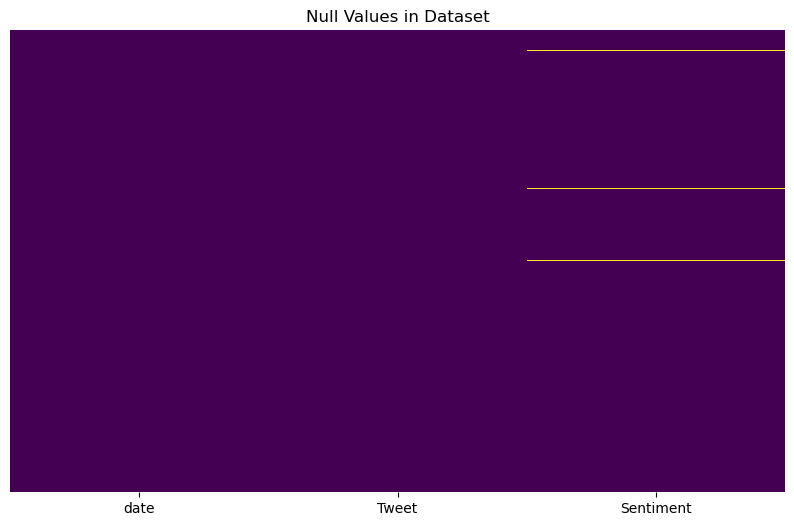

In [38]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Null Values in Dataset')
plt.show()

In [39]:
df = df.dropna(subset=['Sentiment', 'Tweet', 'date'])

In [40]:
df.count()

date         1822
Tweet        1822
Sentiment    1822
dtype: int64

### Drop duplicates and Non-arabic tweet

In [41]:
df = df.drop_duplicates(subset='Tweet', keep='first')

In [42]:
df.count()

date         1719
Tweet        1719
Sentiment    1719
dtype: int64

In [43]:
def filter_farsi_tweets(df):
    # Create a new column to store language detection results
    df['language'] = df['Tweet'].apply(detect)

    # Filter the DataFrame to keep only rows with Arabic language
    filtered_df = df[df['language'] == 'ar']

    # Drop the 'language' column since it's no longer needed
    filtered_df.drop('language', axis=1, inplace=True)

    return filtered_df

In [44]:
filtered_df = filter_farsi_tweets(df)

In [45]:
df = filtered_df


In [46]:
df.count()

date         1551
Tweet        1551
Sentiment    1551
dtype: int64

## PreProccessing

In [47]:
punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ''' + string.punctuation

In [51]:
# Arabic stop words with nltk
nltk.download('stopwords')
stop_words = stopwords.words()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\iraha\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [52]:
arabic_diacritics = re.compile("""
                             ّ    | # Shadda
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)

In [53]:
def preprocess(text):
    
    #remove punctuations
    translator = str.maketrans('', '', punctuations)
    text = text.translate(translator)
    
    # remove Tashkeel
    text = re.sub(arabic_diacritics, '', text)
    
    #remove longation
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)

    #remove opreating char
    text =re.sub(r'(.)\1+', r'\1',text)

    #Replace #word with word
    text = re.sub(r'#([^\s]+)', r'\1', text)

    #text = ' '.join(word for word in text.split() if word not in stop_words)

    return text

In [87]:
df['Tweet'] = df['Tweet'].apply(preprocess)
print(df.head(5))

                  date                                              Tweet  \
0  2020-05-27 04:41:01  ياخي ارسلت اكثر مره احد خدمني عندي شريحه مسبقه...   
1  2020-05-27 03:47:08  ابي افعل انترنت الجيل الخامس لمده شهر محدود لش...   
3  2020-05-27 03:07:36  سلام علكيم عام وانتو بخير انا جيت تطبيق اس سي ...   
4  2020-05-27 01:45:20  اله يحيك تم طلبها طريق اس سي يوم ويجيني النت و...   
6  2020-05-26 22:49:22                طريقه استخراج بدل فاقد لشريحه اس سي   

   Sentiment  
0        0.0  
1       -1.0  
3        0.0  
4        1.0  
6        0.0  


In [88]:
tokenizer = RegexpTokenizer(r'\w+')
df["Tweet"] = df["Tweet"].apply(tokenizer.tokenize)

In [89]:
df["Tweet"].head(10)

0     [ياخي, ارسلت, اكثر, مره, احد, خدمني, عندي, شري...
1     [ابي, افعل, انترنت, الجيل, الخامس, لمده, شهر, ...
3     [سلام, علكيم, عام, وانتو, بخير, انا, جيت, تطبي...
4     [اله, يحيك, تم, طلبها, طريق, اس, سي, يوم, ويجي...
6           [طريقه, استخراج, بدل, فاقد, لشريحه, اس, سي]
7     [اريد, التواصل, موظف, خدمه, العملاء, بتصل, بدو...
8     [السلام, عليكم, عندي, رقم, اس, سي, ماتوصل, رسا...
9     [السلام, عليكم, فقدت, شريحتي, وطلبته, طريق, اس...
10    [السلام, عليكم, الطريقه, لطلب, جهاز, جوال, بنظ...
11    [اقسم, باله, عمركم, سويتوا, شي, كويس, امس, تطب...
Name: Tweet, dtype: object

In [90]:
stopwords_list = stopwords.words('arabic')

In [91]:
stopwords_list

['إذ',
 'إذا',
 'إذما',
 'إذن',
 'أف',
 'أقل',
 'أكثر',
 'ألا',
 'إلا',
 'التي',
 'الذي',
 'الذين',
 'اللاتي',
 'اللائي',
 'اللتان',
 'اللتيا',
 'اللتين',
 'اللذان',
 'اللذين',
 'اللواتي',
 'إلى',
 'إليك',
 'إليكم',
 'إليكما',
 'إليكن',
 'أم',
 'أما',
 'أما',
 'إما',
 'أن',
 'إن',
 'إنا',
 'أنا',
 'أنت',
 'أنتم',
 'أنتما',
 'أنتن',
 'إنما',
 'إنه',
 'أنى',
 'أنى',
 'آه',
 'آها',
 'أو',
 'أولاء',
 'أولئك',
 'أوه',
 'آي',
 'أي',
 'أيها',
 'إي',
 'أين',
 'أين',
 'أينما',
 'إيه',
 'بخ',
 'بس',
 'بعد',
 'بعض',
 'بك',
 'بكم',
 'بكم',
 'بكما',
 'بكن',
 'بل',
 'بلى',
 'بما',
 'بماذا',
 'بمن',
 'بنا',
 'به',
 'بها',
 'بهم',
 'بهما',
 'بهن',
 'بي',
 'بين',
 'بيد',
 'تلك',
 'تلكم',
 'تلكما',
 'ته',
 'تي',
 'تين',
 'تينك',
 'ثم',
 'ثمة',
 'حاشا',
 'حبذا',
 'حتى',
 'حيث',
 'حيثما',
 'حين',
 'خلا',
 'دون',
 'ذا',
 'ذات',
 'ذاك',
 'ذان',
 'ذانك',
 'ذلك',
 'ذلكم',
 'ذلكما',
 'ذلكن',
 'ذه',
 'ذو',
 'ذوا',
 'ذواتا',
 'ذواتي',
 'ذي',
 'ذين',
 'ذينك',
 'ريث',
 'سوف',
 'سوى',
 'شتان',
 'عدا',
 'عسى',
 'عل'

In [92]:
list_To_Str = ' '.join([str(elem) for elem in stopwords_list]) 

In [93]:
list_To_Str

'إذ إذا إذما إذن أف أقل أكثر ألا إلا التي الذي الذين اللاتي اللائي اللتان اللتيا اللتين اللذان اللذين اللواتي إلى إليك إليكم إليكما إليكن أم أما أما إما أن إن إنا أنا أنت أنتم أنتما أنتن إنما إنه أنى أنى آه آها أو أولاء أولئك أوه آي أي أيها إي أين أين أينما إيه بخ بس بعد بعض بك بكم بكم بكما بكن بل بلى بما بماذا بمن بنا به بها بهم بهما بهن بي بين بيد تلك تلكم تلكما ته تي تين تينك ثم ثمة حاشا حبذا حتى حيث حيثما حين خلا دون ذا ذات ذاك ذان ذانك ذلك ذلكم ذلكما ذلكن ذه ذو ذوا ذواتا ذواتي ذي ذين ذينك ريث سوف سوى شتان عدا عسى عل على عليك عليه عما عن عند غير فإذا فإن فلا فمن في فيم فيما فيه فيها قد كأن كأنما كأي كأين كذا كذلك كل كلا كلاهما كلتا كلما كليكما كليهما كم كم كما كي كيت كيف كيفما لا لاسيما لدى لست لستم لستما لستن لسن لسنا لعل لك لكم لكما لكن لكنما لكي لكيلا لم لما لن لنا له لها لهم لهما لهن لو لولا لوما لي لئن ليت ليس ليسا ليست ليستا ليسوا ما ماذا متى مذ مع مما ممن من منه منها منذ مه مهما نحن نحو نعم ها هاتان هاته هاتي هاتين هاك هاهنا هذا هذان هذه هذي هذين هكذا هل هلا هم هما هن هنا هن

In [94]:
#remove stop word
df["Tweet"] = df["Tweet"].apply(lambda text: [word for word in text if word not in stopwords_list])

In [95]:
y=df['Sentiment']
y.value_counts()

Sentiment
 0.0    740
-1.0    610
 1.0    201
Name: count, dtype: int64

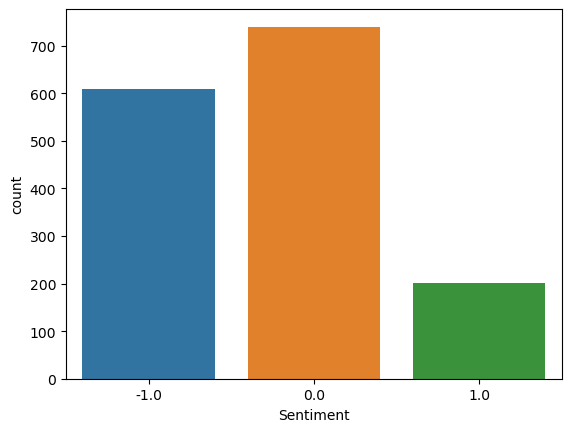

In [96]:
sns.countplot(data= df, x = "Sentiment")
plt.show()

## Feature Extraction

In [97]:
# Initialize the TfidfVectorizer
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    ngram_range=(1, 1),
    max_features=10000
)


In [98]:
unigramdataGet = word_vectorizer.fit_transform(df['Tweet'].astype('str'))
unigramdataGet =unigramdataGet.toarray()

In [99]:
vocab = word_vectorizer.get_feature_names_out()

In [100]:
unigramdata_features = pd.DataFrame(np.round(unigramdataGet, 1), columns=vocab)

In [101]:
unigramdata_features[unigramdata_features > 0] = 1

In [102]:
# Print the first few rows of the DataFrame
unigramdata_features

,ac,cc,dsl,esim,gt,ksa,my,mystc,mystcبتشوفي,pay,...,يوصلوها,يوفقكم,يوفقهم,يوقفونه,يوم,يومذن,يومك,يوميا,يومين,ٱخر
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1546,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1547,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1548,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1549,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [103]:
y=df['Sentiment']
X=unigramdata_features

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=333)


# Decision Tree (DT)

In [105]:
Ds=DecisionTreeClassifier()

In [106]:
# Define the hyperparameter grid to search
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy'] }

In [74]:
# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(Ds, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20, 30],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [75]:
# Print the best hyperparameters found
print("Best Hyperparameters:", grid_search.best_params_)


Best Hyperparameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10}


In [76]:
# Use the best model for predictions
best_classifier = grid_search.best_estimator_
y_pred = best_classifier.predict(X_test)

In [77]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')


Accuracy: 0.5901287553648069


In [78]:
# Display classification report
print('\nClassification Report:')
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

        -1.0       0.64      0.46      0.54       174
         0.0       0.59      0.82      0.68       234
         1.0       0.23      0.05      0.08        58

    accuracy                           0.59       466
   macro avg       0.49      0.44      0.43       466
weighted avg       0.56      0.59      0.55       466



# Naive Bayes (NB)

In [79]:
y_train.value_counts()

Sentiment
 0.0    506
-1.0    436
 1.0    143
Name: count, dtype: int64

In [80]:
# Ensure 'Tweet' column contains strings
df['Tweet'] = df['Tweet'].astype(str)

In [81]:
# Initialize the Multinomial Naive Bayes classifier
nb_classifier = MultinomialNB()

In [82]:
# Define the hyperparameter grid
param_grid = {
    'alpha': [0.01, 0.1, 1.0, 10.0],  
}

In [83]:
# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=nb_classifier, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.01, 0.1, 1.0, 10.0]}, scoring='accuracy')

In [84]:
# Get the best hyperparameters
best_alpha = grid_search.best_params_['alpha']
print(f'Best alpha: {best_alpha}')

Best alpha: 1.0


In [85]:
# Train the model with the best hyperparameters
nb_classifier = MultinomialNB(alpha=best_alpha)
nb_classifier.fit(X_train, y_train)

# Make predictions
predictions = nb_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
classification_report_str = classification_report(y_test, predictions)

print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:\n', classification_report_str)

Accuracy: 0.6996
Classification Report:
               precision    recall  f1-score   support

        -1.0       0.78      0.66      0.71       174
         0.0       0.69      0.87      0.77       234
         1.0       0.36      0.14      0.20        58

    accuracy                           0.70       466
   macro avg       0.61      0.56      0.56       466
weighted avg       0.68      0.70      0.68       466



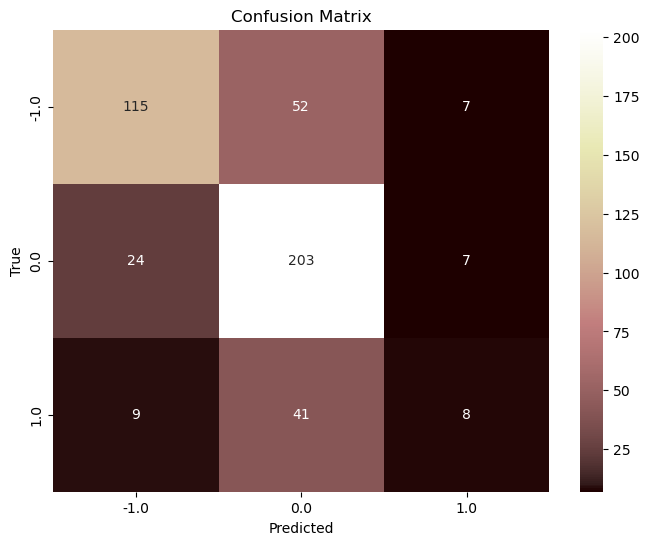

In [86]:
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='pink', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Support Vector Machine (SVM)